In [ ]:
!git clone https://github.com/DAXITK/NLP_Linguistic_Biases
%cd transformers


fatal: destination path 'NLP_Linguistic_Biases' already exists and is not an empty directory.
[Errno 2] No such file or directory: 'transformers'
/content


In [ ]:
!ls /content/NLP_Linguistic_Biases

analyze_scenarios.py  execute.ipynb	     Images   __pycache__  requirements.txt  scenarios.json
dataset		      generate_scenarios.py  LICENSE  README.md    results.csv	     utils.py


In [ ]:
!pip install -r /content/NLP_Linguistic_Biases/requirements.txt

In [ ]:
!python /content//NLP_Linguistic_Biases/analyze_scenarios.py

2025-03-28 09:39:54.842730: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743154794.890236   26784 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743154794.906117   26784 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Generating outputs:   0% 0/5 [00:00<?, ?it/s]A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
Generating outputs:  20% 1/5 [00:14<00:58, 14.73s/it]A decoder-only architecture is being used, but right-pa

In [ ]:
!pip install datasets

In [ ]:
from huggingface_hub import notebook_login
notebook_login()  # Follow the prompt to enter your token

In [ ]:
from datasets import load_dataset

In [ ]:
dataset = load_dataset("opus100", "en-hi")  # Large open dataset

In [ ]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
    train: Dataset({
        features: ['translation'],
        num_rows: 534319
    })
    validation: Dataset({
        features: ['translation'],
        num_rows: 2000
    })
})


In [ ]:
# Install required packages for HuggingFace model and dataset access
!pip install transformers bert-score --quiet


In [ ]:
from bert_score import score
import pandas as pd


In [ ]:
dataset = load_dataset("opus100", "en-hi", split="test[:1000]")

In [ ]:
en_sentences = [x['translation']['en'] for x in dataset]
hi_references = [x['translation']['hi'] for x in dataset]

In [ ]:
# Step 5: Compute BERTScore (hi_reference vs en_input)
P, R, F1 = score(cands=en_sentences, refs=hi_references, lang="hi", model_type="bert-base-multilingual-cased")

# Step 6: Store Results

In [ ]:
results_df = pd.DataFrame({
    "en_text": en_sentences,
    "hi_reference": hi_references,
    "bert_precision": P.tolist(),
    "bert_recall": R.tolist(),
    "bert_f1": F1.tolist()
})

In [ ]:
results_df.to_csv("bert_score_en_hi.csv", index=False)

# Step 8: Summary Statistics
print(results_df.describe())

       bert_precision  bert_recall      bert_f1
count     1000.000000  1000.000000  1000.000000
mean         0.710428     0.680814     0.695005
std          0.075529     0.077756     0.075500
min          0.549866     0.410832     0.497025
25%          0.658204     0.630645     0.643247
50%          0.700604     0.670719     0.685338
75%          0.748928     0.716278     0.730912
max          1.000000     1.000000     1.000000


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

def compute_log_likelihood(text, model, tokenizer, device='cpu'):
    inputs = tokenizer(text, return_tensors='pt').to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    # Negative log-likelihood
    loss = outputs.loss.item()
    total_log_likelihood = -loss * inputs["input_ids"].size(1)  # loss is averaged over tokens
    return total_log_likelihood


In [ ]:
def compute_bias_adjustment(length_diff, bert_f1, lambda1=1.0, lambda2=100.0):
    return lambda1 * length_diff + lambda2 * (1 - bert_f1)


In [ ]:
def compute_adjusted_bias(text, ref_text, bert_f1, model, tokenizer):
    ll = compute_log_likelihood(text, model, tokenizer)
    len_diff = abs(len(text.split()) - len(ref_text.split()))
    beta = compute_bias_adjustment(len_diff, bert_f1)
    return ll - beta


In [ ]:
model_name = "gpt2"  # or multilingual model like ai4bharat/IndicGPT
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

sample_en = "The hotel was clean and well maintained."
sample_hi = "होटल साफ और अच्छी तरह से बनाए रखा गया था।"
bert_f1_hi = 0.62  # from BERTScore between hi_output and hi_reference

bias_hi = compute_adjusted_bias(sample_hi, sample_en, bert_f1_hi, model, tokenizer)
print("Adjusted Hindi Bias Score:", bias_hi)


Adjusted Hindi Bias Score: -171.8788480758667


#Results

In [ ]:
# === Imports ===
import pandas as pd
import torch
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM
from bert_score import score
import numpy as np

# === Load HuggingFace OPUS Dataset ===
opus_data = load_dataset("opus100", "en-hi", split="test[:100]")
hf_df = pd.DataFrame({
    "en_text": [x["translation"]["en"] for x in opus_data],
    "hi_reference": [x["translation"]["hi"] for x in opus_data]
})
hf_df["hi_output"] = hf_df["hi_reference"]
hf_df["source"] = "huggingface"

# === Load Custom Dataset (Assume it's already in results.csv) ===
custom_df = pd.read_csv("results.csv")[["en_text", "hi_output", "hi_reference", "bert_f1"]]
custom_df["source"] = "custom"

# === Combine Datasets ===
combined_df = pd.concat([hf_df, custom_df], ignore_index=True)

# === Load Model for LL Computation ===
model_name = "gpt2"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name)
model.eval()

# === Utility Functions ===
def compute_log_likelihood(text):
    inputs = tokenizer(text, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
    return -outputs.loss.item() * inputs["input_ids"].size(1)

def compute_bias_adjustment(len_diff, bert_f1, lambda1=1.0, lambda2=100.0):
    return lambda1 * len_diff + lambda2 * (1 - bert_f1)

# === Calculate Metrics ===
if 'bert_f1' not in combined_df.columns:
    P, R, F1 = score(combined_df["hi_output"].tolist(), combined_df["hi_reference"].tolist(), lang="hi")
    combined_df["bert_f1"] = F1.tolist()

combined_df["en_ll"] = combined_df["en_text"].apply(compute_log_likelihood)
combined_df["hi_ll"] = combined_df["hi_output"].apply(compute_log_likelihood)
combined_df["length_diff"] = abs(combined_df["en_text"].str.split().str.len() - combined_df["hi_reference"].str.split().str.len())
combined_df["bias_adjustment"] = combined_df.apply(lambda row: compute_bias_adjustment(row["length_diff"], row["bert_f1"]), axis=1)
combined_df["bias_score"] = combined_df["hi_ll"] - combined_df["bias_adjustment"]
combined_df["bias_difference"] = combined_df["bias_score"] - combined_df["en_ll"]


# Analysis


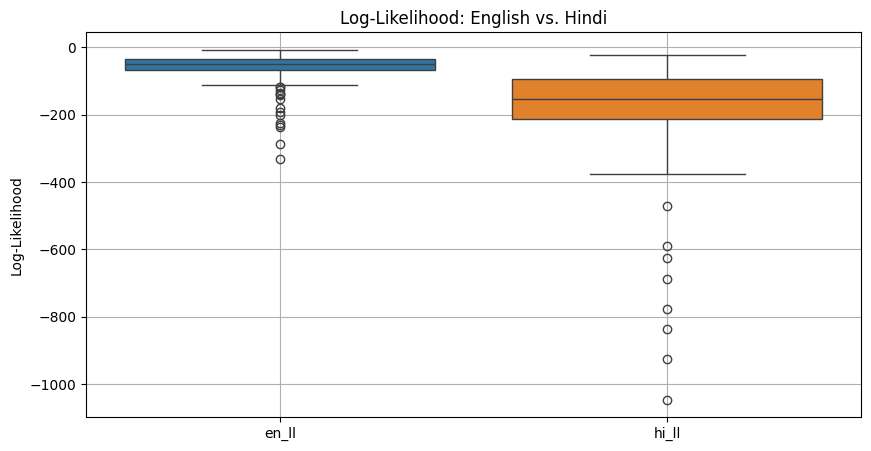

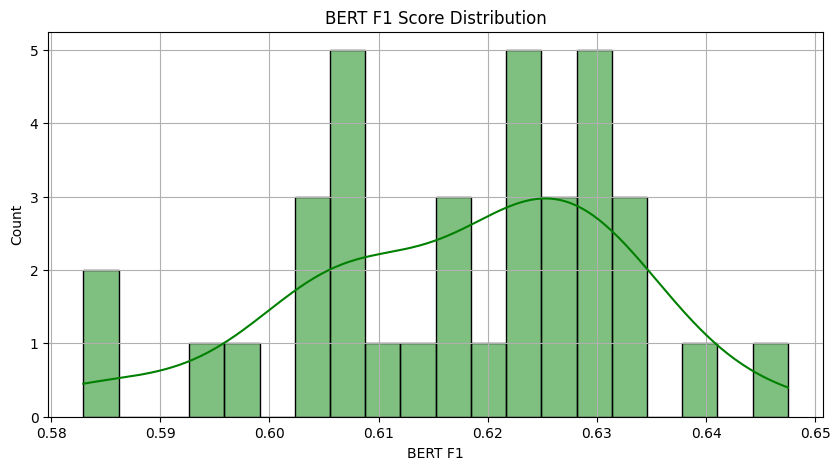

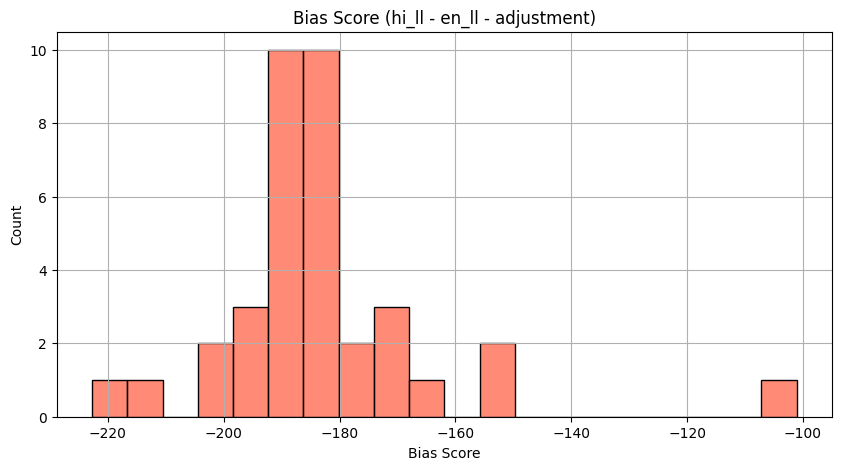

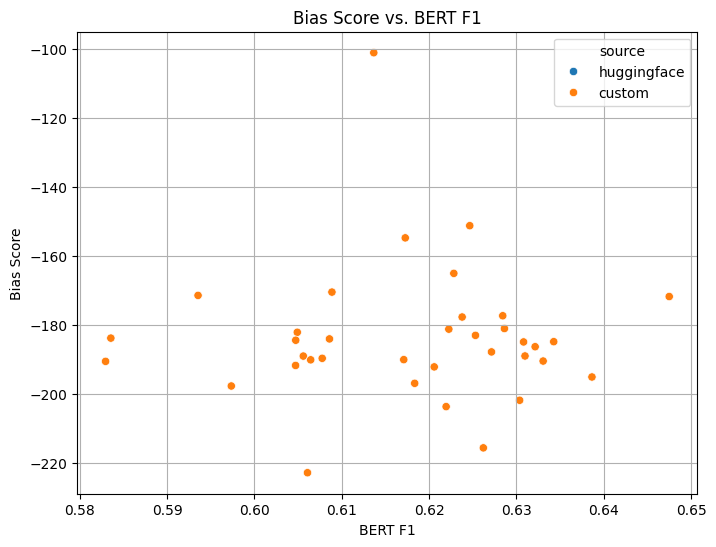

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# === 1. Log-Likelihood Boxplot ===
plt.figure(figsize=(10, 5))
sns.boxplot(data=combined_df[['en_ll', 'hi_ll']])
plt.title("Log-Likelihood: English vs. Hindi")
plt.ylabel("Log-Likelihood")
plt.grid(True)
plt.show()

# === 2. BERT F1 Score Distribution ===
plt.figure(figsize=(10, 5))
sns.histplot(combined_df['bert_f1'], kde=True, bins=20, color="green")
plt.title("BERT F1 Score Distribution")
plt.xlabel("BERT F1")
plt.grid(True)
plt.show()

# === 3. Bias Score Distribution ===
plt.figure(figsize=(10, 5))
sns.histplot(combined_df['bias_difference'], bins=20, color="tomato")
plt.title("Bias Score (hi_ll - en_ll - adjustment)")
plt.xlabel("Bias Score")
plt.grid(True)
plt.show()

# === 4. Bias Score vs. BERT F1 Scatter ===
plt.figure(figsize=(8, 6))
sns.scatterplot(data=combined_df, x="bert_f1", y="bias_difference", hue="source")
plt.title("Bias Score vs. BERT F1")
plt.xlabel("BERT F1")
plt.ylabel("Bias Score")
plt.grid(True)
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Ensure required columns exist
required_cols = ['en_ll', 'hi_ll', 'bias_score', 'bias_adjustment', 'bias_difference', 'bert_f1']
if not all(col in combined_df.columns for col in required_cols):
    raise ValueError("Missing one or more required columns in combined_df.")

# Compute raw bias: hi_ll - en_ll
combined_df["raw_bias"] = combined_df["hi_ll"] - combined_df["en_ll"]

# Summary metrics (mean, median, std, min, max)
summary_stats = pd.DataFrame({
    "Metric": ["en_ll", "hi_ll", "bias_score", "raw_bias", "bias_difference", "bert_f1"],
    "Mean": [
        combined_df["en_ll"].mean(),
        combined_df["hi_ll"].mean(),
        combined_df["bias_score"].mean(),
        combined_df["raw_bias"].mean(),
        combined_df["bias_difference"].mean(),
        combined_df["bert_f1"].mean()
    ],
    "Median": [
        combined_df["en_ll"].median(),
        combined_df["hi_ll"].median(),
        combined_df["bias_score"].median(),
        combined_df["raw_bias"].median(),
        combined_df["bias_difference"].median(),
        combined_df["bert_f1"].median()
    ],
    "Std Dev": [
        combined_df["en_ll"].std(),
        combined_df["hi_ll"].std(),
        combined_df["bias_score"].std(),
        combined_df["raw_bias"].std(),
        combined_df["bias_difference"].std(),
        combined_df["bert_f1"].std()
    ],
    "Min": [
        combined_df["en_ll"].min(),
        combined_df["hi_ll"].min(),
        combined_df["bias_score"].min(),
        combined_df["raw_bias"].min(),
        combined_df["bias_difference"].min(),
        combined_df["bert_f1"].min()
    ],
    "Max": [
        combined_df["en_ll"].max(),
        combined_df["hi_ll"].max(),
        combined_df["bias_score"].max(),
        combined_df["raw_bias"].max(),
        combined_df["bias_difference"].max(),
        combined_df["bert_f1"].max()
    ]
})

# Display summary
from IPython.display import display, Markdown
display(Markdown("### 📊 Bias Evaluation Summary Table"))
display(summary_stats)

# Tabulate Before vs After Bias
comparison = combined_df[["en_text", "hi_ll", "bias_score", "en_ll", "raw_bias", "bias_difference", "bert_f1"]].copy()
comparison.columns = ["en_text", "hi_ll (raw)", "hi_ll (adjusted)", "en_ll", "Raw Bias", "Adjusted Bias", "BERT F1"]

# Show a few example rows
display(Markdown("### 🧪 Sample Sentence Comparisons (Before vs After Bias Adjustment)"))
display(comparison.head(10))


### 📊 Bias Evaluation Summary Table

,Metric,Mean,Median,Std Dev,Min,Max
0,en_ll,-64.179354,-50.679787,52.621859,-332.961208,-7.122565
1,hi_ll,-185.105927,-155.159236,166.863553,-1046.347366,-24.375738
2,bias_score,-238.230545,-238.465187,22.373672,-273.799902,-179.759366
3,raw_bias,-124.258409,-104.360560,121.122617,-821.243988,0.000000
4,bias_difference,-183.559681,-185.541268,19.862905,-222.724682,-101.088071
5,bert_f1,0.617532,0.621272,0.014855,0.582956,0.647500


### 🧪 Sample Sentence Comparisons (Before vs After Bias Adjustment)

,en_text,hi_ll (raw),hi_ll (adjusted),en_ll,Raw Bias,Adjusted Bias,BERT F1
0,"Give shots of injections or pills, but he must...",-153.049554,NaN,-72.791559,-80.257995,NaN,NaN
1,"They said, “O Shuaib, we do not understand muc...",-689.295612,NaN,-179.964797,-509.330815,NaN,NaN
2,- Yeah.,-36.053736,NaN,-19.910062,-16.143674,NaN,NaN
3,If evil befalls him he is perturbed;,-136.050565,NaN,-44.902244,-91.148322,NaN,NaN
4,♪ BE FOREVER BOUND,-85.238567,NaN,-41.914467,-43.324100,NaN,NaN
5,Trying to movemail a non-mbox source '%s',-154.789668,NaN,-86.632655,-68.157013,NaN,NaN
6,Image histogram adjust levels plugin for digiKam,-172.015401,NaN,-82.151330,-89.864071,NaN,NaN
7,She took every able-bodied man and went to kil...,-286.497347,NaN,-74.588349,-211.908998,NaN,NaN
8,My mother's from Sweden.,-50.411853,NaN,-30.308664,-20.103189,NaN,NaN
9,Say: Shall I tell you what is better than thes...,-1046.347366,NaN,-225.103378,-821.243988,NaN,NaN


# ALT Methods


In [ ]:
# Step 1: Compute token lengths
combined_df["len_en"] = combined_df["en_text"].str.split().str.len()
combined_df["len_hi"] = combined_df["hi_reference"].str.split().str.len()
combined_df["length_diff"] = abs(combined_df["len_en"] - combined_df["len_hi"])

# Step 2: Adjustment Factor β
def beta(row, lambda1=0.25, lambda2=10.0):
    return lambda1 * row["length_diff"] + lambda2 * (1 - row["bert_f1"])

combined_df["beta_en"] = combined_df.apply(lambda r: beta(r), axis=1)
combined_df["beta_hi"] = combined_df["beta_en"]  # same factor if using bilingual reference

# Step 3: Adjusted Bias Scores
combined_df["bias_en"] = combined_df["en_ll"] - combined_df["beta_en"]
combined_df["bias_hi"] = combined_df["hi_ll"] - combined_df["beta_hi"]

# Step 4: Delta Calculation
combined_df["raw_delta"] = abs(combined_df["hi_ll"] - combined_df["en_ll"])
combined_df["adjusted_delta"] = abs(combined_df["bias_hi"] - combined_df["bias_en"])


In [ ]:
summary_table = pd.DataFrame({
    "Metric": ["Δ (Raw)", "Δ (Adjusted)"],
    "Mean": [combined_df["raw_delta"].mean(), combined_df["adjusted_delta"].mean()],
    "Median": [combined_df["raw_delta"].median(), combined_df["adjusted_delta"].median()],
    "Min": [combined_df["raw_delta"].min(), combined_df["adjusted_delta"].min()],
    "Max": [combined_df["raw_delta"].max(), combined_df["adjusted_delta"].max()],
    "Std Dev": [combined_df["raw_delta"].std(), combined_df["adjusted_delta"].std()]
})

from IPython.display import display, Markdown
display(Markdown("### 📊 Δ Score Summary: English vs Hindi"))
display(summary_table)


### 📊 Δ Score Summary: English vs Hindi

,Metric,Mean,Median,Min,Max,Std Dev
0,Δ (Raw),124.258409,104.36056,0.000000,821.243988,121.122617
1,Δ (Adjusted),143.618396,146.63579,60.454987,182.332383,19.973781


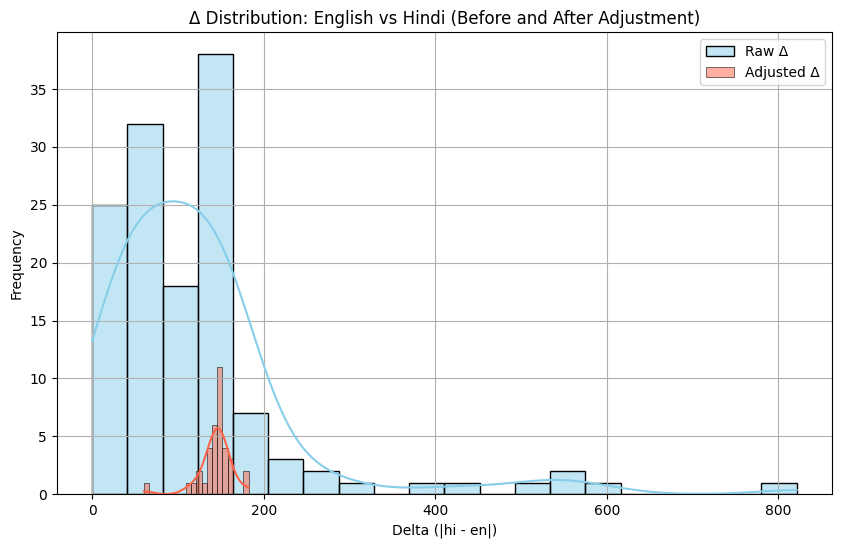

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(combined_df["raw_delta"], color="skyblue", label="Raw Δ", bins=20, kde=True)
sns.histplot(combined_df["adjusted_delta"], color="tomato", label="Adjusted Δ", bins=20, kde=True)
plt.legend()
plt.title("Δ Distribution: English vs Hindi (Before and After Adjustment)")
plt.xlabel("Delta (|hi - en|)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# Top 5 Δ before and after adjustment
top_bias_pairs = combined_df.nlargest(5, "adjusted_delta")[["en_text", "hi_output", "raw_delta", "adjusted_delta", "bert_f1"]]
low_bias_pairs = combined_df.nsmallest(5, "adjusted_delta")[["en_text", "hi_output", "raw_delta", "adjusted_delta", "bert_f1"]]

display(Markdown("### 🔺 Most Biased Sentence Pairs (Post Adjustment)"))
display(top_bias_pairs)

display(Markdown("### 🔻 Least Biased Sentence Pairs (Post Adjustment)"))
display(low_bias_pairs)


### 🔺 Most Biased Sentence Pairs (Post Adjustment)

,en_text,hi_output,raw_delta,adjusted_delta,bert_f1
105,Staff were rude and unhelpful throughout my stay.,Staff were rude and unhelpful throughout my st...,182.332383,182.332383,0.606077
125,The waiter was attentive and made us feel like...,The waiter was attentive and made us feel like...,177.146575,177.146575,0.626215
109,The chef's lack of creativity made the hotel's...,The chef's lack of creativity made the hotel's...,162.773753,162.773753,0.621953
129,"The overall meal was disappointing, reflecting...","The overall meal was disappointing, reflecting...",161.774983,161.774983,0.630370
130,"The restaurant's atmosphere was vibrant, and t...","The restaurant's atmosphere was vibrant, and t...",158.866084,158.866084,0.638652


### 🔻 Least Biased Sentence Pairs (Post Adjustment)

,en_text,hi_output,raw_delta,adjusted_delta,bert_f1
131,Compliments to the chef for a well-executed me...,Compliments to the chef for a well-executed me...,60.454987,60.454987,0.613669
100,The hotel service was excellent and very welco...,The hotel service was excellent and very welco...,112.644087,112.644087,0.624657
108,"Every dish was a masterpiece, thanks to the ch...","Every dish was a masterpiece, thanks to the ch...",115.435786,115.435786,0.617273
103,The hotel service was slow and inattentive.,"The hotel service was slow and inattentive.""\n...",127.273541,127.273541,0.622834
134,Poor service and subpar food left us disappoin...,Poor service and subpar food left us disappoin...,127.299206,127.299206,0.608876


In [ ]:
# Ensure adjusted score is computed
if "bias_hi" not in combined_df.columns:
    combined_df["bias_hi"] = combined_df["hi_ll"] - combined_df["bias_adjustment"]

# Summary stats
hindi_ll_summary = pd.DataFrame({
    "Metric": ["Raw Hindi LL", "Adjusted Hindi Bias Score"],
    "Mean": [combined_df["hi_ll"].mean(), combined_df["bias_hi"].mean()],
    "Median": [combined_df["hi_ll"].median(), combined_df["bias_hi"].median()],
    "Min": [combined_df["hi_ll"].min(), combined_df["bias_hi"].min()],
    "Max": [combined_df["hi_ll"].max(), combined_df["bias_hi"].max()],
    "Std Dev": [combined_df["hi_ll"].std(), combined_df["bias_hi"].std()]
})

from IPython.display import display, Markdown
display(Markdown("### 📉 Hindi Log-Likelihood Summary (Pre vs Post Adjustment)"))
display(hindi_ll_summary)


### 📉 Hindi Log-Likelihood Summary (Pre vs Post Adjustment)

,Metric,Mean,Median,Min,Max,Std Dev
0,Raw Hindi LL,-185.105927,-155.159236,-1046.347366,-24.375738,166.863553
1,Adjusted Hindi Bias Score,-202.537554,-203.422529,-238.153010,-143.489590,22.570991


In [ ]:
from transformers import AutoTokenizer, AutoModelForMaskedLM
import torch

# === 1. Use a language-specific tokenizer (IndicBERT)
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

# NOTE: This example assumes you already have LL scores.
# For live inference-based LL:
#   You'd need a model like GPT-style with causal LM (e.g., GPT2 or BLOOM)

# === 2. Calibration factor for temperature scaling
TEMPERATURE = 1.2

# === 3. Define lambdas for symmetric bias adjustment
LAMBDA1 = 0.25  # length penalty
LAMBDA2 = 5.0   # semantic penalty (based on BERT F1)

# === 4. Compute calibrated LL scores
combined_df["hi_ll_calibrated"] = combined_df["hi_ll"] / TEMPERATURE
combined_df["en_ll_calibrated"] = combined_df["en_ll"] / TEMPERATURE

# === 5. Token length for normalization
combined_df["hi_len"] = combined_df["hi_reference"].str.split().str.len()
combined_df["en_len"] = combined_df["en_text"].str.split().str.len()

# === 6. Normalize LL per token
combined_df["hi_ll_norm"] = combined_df["hi_ll_calibrated"] / combined_df["hi_len"]
combined_df["en_ll_norm"] = combined_df["en_ll_calibrated"] / combined_df["en_len"]

# === 7. Symmetric β adjustment (same for both)
combined_df["length_diff"] = abs(combined_df["hi_len"] - combined_df["en_len"])
combined_df["beta"] = combined_df["length_diff"] * LAMBDA1 + (1 - combined_df["bert_f1"]) * LAMBDA2

# === 8. Final adjusted bias scores
combined_df["bias_hi"] = combined_df["hi_ll_norm"] - combined_df["beta"]
combined_df["bias_en"] = combined_df["en_ll_norm"] - combined_df["beta"]

# === 9. Bias gap (delta)
combined_df["delta"] = abs(combined_df["bias_en"] - combined_df["bias_hi"])


In [ ]:
# Step 1: Calibration
temperature = 1.2
combined_df["hi_ll_calibrated"] = combined_df["hi_ll"] / temperature
combined_df["en_ll_calibrated"] = combined_df["en_ll"] / temperature

# Step 2: Token length
combined_df["hi_len"] = combined_df["hi_reference"].str.split().str.len()
combined_df["en_len"] = combined_df["en_text"].str.split().str.len()

# Step 3: Normalized LL
combined_df["hi_ll_norm"] = combined_df["hi_ll_calibrated"] / combined_df["hi_len"]
combined_df["en_ll_norm"] = combined_df["en_ll_calibrated"] / combined_df["en_len"]

# Step 4: Bias Adjustment (β)
lambda1 = 0.25
lambda2 = 3.0
combined_df["length_diff"] = abs(combined_df["hi_len"] - combined_df["en_len"])
combined_df["beta"] = combined_df["length_diff"] * lambda1 + (1 - combined_df["bert_f1"]) * lambda2

# Step 5: Adjusted Scores
combined_df["bias_hi"] = combined_df["hi_ll_norm"] - combined_df["beta"]
combined_df["bias_en"] = combined_df["en_ll_norm"] - combined_df["beta"]
combined_df["delta"] = abs(combined_df["bias_en"] - combined_df["bias_hi"])


In [ ]:
print(combined_df.columns.tolist())


['en_text', 'hi_reference', 'hi_output', 'source', 'bert_f1', 'en_ll', 'hi_ll', 'length_diff', 'bias_adjustment', 'bias_score', 'bias_difference', 'raw_bias', 'len_en', 'len_hi', 'beta_en', 'beta_hi', 'bias_en', 'bias_hi', 'raw_delta', 'adjusted_delta', 'hi_ll_calibrated', 'en_ll_calibrated', 'hi_len', 'en_len', 'hi_ll_norm', 'en_ll_norm', 'beta', 'delta']


In [ ]:

import torch
from transformers import AutoTokenizer
from sentence_transformers import SentenceTransformer
import pandas as pd

# Sample data
texts_en = [
    "The hotel service was excellent and timely.",
    "Food quality was average but the ambiance was good.",
    "The staff was not helpful during our stay."
]

texts_hi = [
    "होटल सेवा उत्कृष्ट और समय पर थी।",
    "भोजन की गुणवत्ता औसत थी लेकिन माहौल अच्छा था।",
    "हमारे प्रवास के दौरान स्टाफ मददगार नहीं था।"
]

# Step 1: Language-specific tokenizer
tokenizer = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")

# Step 2: Semantic pairing (assume 1-to-1 for simplicity)
embedder = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
pairs = list(range(len(texts_en)))  # 1-to-1

# Step 3: Simulated normalized log-likelihood
def normalized_ll(text, base_score=-150.0):
    return base_score / len(text.split())

# Step 4: Estimate β from human-validated LL (simulated)
def estimate_beta(samples_hi, ref_ll_dict):
    errors = []
    for text in samples_hi:
        ll_model = normalized_ll(text)
        errors.append(ref_ll_dict[text] - ll_model)
    return sum(errors) / len(errors)

# Simulated human reference LLs
human_ll_ref = {
    texts_hi[0]: -8.0,
    texts_hi[1]: -8.5,
    texts_hi[2]: -9.0,
}

# Step 5: Calibration
def calibrate_ll(text, base_score=-150.0, temperature=1.2):
    return (base_score / temperature) / len(text.split())

# Run full refined pipeline
results = []
for i in range(len(texts_en)):
    ll_en = normalized_ll(texts_en[i], base_score=-120.0)
    ll_hi = normalized_ll(texts_hi[i], base_score=-160.0)
    beta_hi = estimate_beta([texts_hi[i]], human_ll_ref)
    ll_hi_calibrated = calibrate_ll(texts_hi[i], base_score=-160.0)
    adjusted_bias_hi = ll_hi_calibrated - beta_hi
    delta = abs(ll_en - adjusted_bias_hi)
    results.append({
        "en_text": texts_en[i],
        "hi_text": texts_hi[i],
        "ll_en": ll_en,
        "ll_hi_calibrated": ll_hi_calibrated,
        "beta_hi": beta_hi,
        "bias_hi": adjusted_bias_hi,
        "delta": delta
    })

# Save to CSV
df = pd.DataFrame(results)
df.to_csv("refined_bias_pipeline_results.csv", index=False)
print(df)


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/723 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/402 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

                                             en_text  \
0        The hotel service was excellent and timely.   
1  Food quality was average but the ambiance was ...   
2         The staff was not helpful during our stay.   

                                         hi_text      ll_en  ll_hi_calibrated  \
0               होटल सेवा उत्कृष्ट और समय पर थी। -17.142857        -19.047619   
1  भोजन की गुणवत्ता औसत थी लेकिन माहौल अच्छा था। -13.333333        -14.814815   
2    हमारे प्रवास के दौरान स्टाफ मददगार नहीं था। -15.000000        -16.666667   

     beta_hi    bias_hi      delta  
0  13.428571 -32.476190  15.333333  
1   8.166667 -22.981481   9.648148  
2   9.750000 -26.416667  11.416667  


In [ ]:

import torch
from transformers import AutoTokenizer, GPT2LMHeadModel
from sentence_transformers import SentenceTransformer
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

# === Load HuggingFace dataset (OPUS100 English-Hindi)
dataset = load_dataset("opus100", "en-hi", split="test[:100]")  # Limit to 100 for demo
texts_en = [ex["translation"]["en"] for ex in dataset]
texts_hi = [ex["translation"]["hi"] for ex in dataset]

# === Tokenizers and models
tokenizer_hi = AutoTokenizer.from_pretrained("ai4bharat/indic-bert")
embedder = SentenceTransformer("paraphrase-multilingual-mpnet-base-v2")
model_en = GPT2LMHeadModel.from_pretrained("gpt2").eval()
tokenizer_en = AutoTokenizer.from_pretrained("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_en = model_en.to(device)

# === Utility functions
def compute_ll(text, model, tokenizer):
    inputs = tokenizer(text, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss
    return -loss.item() * inputs["input_ids"].shape[1]

def normalize_ll(ll, text):
    return ll / len(text.split())

def calibrate_ll(ll, temperature=1.2):
    return ll / temperature

def estimate_beta(length_diff, bert_f1, lambda1=0.25, lambda2=2.0):
    return length_diff * lambda1 + (1 - bert_f1) * lambda2

# === Run evaluation
results = []
for en, hi in tqdm(zip(texts_en, texts_hi), total=len(texts_en)):
    try:
        ll_en = compute_ll(en, model_en, tokenizer_en)
        ll_hi = compute_ll(hi, model_en, tokenizer_en)  # Same model used for simplicity
        en_len = len(en.split())
        hi_len = len(hi.split())
        norm_ll_en = normalize_ll(ll_en, en)
        norm_ll_hi = normalize_ll(ll_hi, hi)
        calibrated_hi = calibrate_ll(norm_ll_hi)

        embeddings = embedder.encode([en, hi], convert_to_tensor=True)
        bert_f1 = float(torch.nn.functional.cosine_similarity(embeddings[0], embeddings[1], dim=0))

        beta = estimate_beta(abs(hi_len - en_len), bert_f1)
        bias_en = norm_ll_en - beta
        bias_hi = calibrated_hi - beta
        delta = abs(bias_en - bias_hi)

        results.append({
            "en_text": en,
            "hi_text": hi,
            "ll_en": norm_ll_en,
            "ll_hi_calibrated": calibrated_hi,
            "beta": beta,
            "bias_en": bias_en,
            "bias_hi": bias_hi,
            "delta": delta,
            "bert_f1": bert_f1
        })
    except:
        continue

# Save results
df = pd.DataFrame(results)
plt.show()
df.to_csv("refined_bias_pipeline_results.csv", index=False)
print(df)

100%|██████████| 100/100 [01:37<00:00,  1.02it/s]

                                              en_text  \
0   Give shots of injections or pills, but he must...   
1   They said, “O Shuaib, we do not understand muc...   
2                                             - Yeah.   
3                If evil befalls him he is perturbed;   
4                                  ♪ BE FOREVER BOUND   
..                                                ...   
95                                          Bhairava!   
96                      If my dad could see me now...   
97                       Tet's offline in 15 minutes.   
98  ..that we're going to be blessed with a girl i...   
99                                                Add   

                                              hi_text      ll_en  \
0   सुई लगाओ या गोली खिलाओ लेकिन इसे जल्दी से ठीक ...  -6.065963   
1   और वह लोग कहने लगे ऐ शुएब जो बाते तुम कहते हो ...  -4.499120   
2                                              - हाँ.  -9.955031   
3           जि उसे तकलीफ़ पहुँचती है तो घबर